# Linear Regression with TensorFlow

Regression analysis is a statistical process for estimating the relationships among variables. As an example of a regression model, we focus on the simplest case: linear regression. In linear regression, we assume that
$$\mathbb{E}[y|x] = b + w^\top x,$$
where $y$ is the *dependent variable*, $x$ is the *independent variable*, $w$ are the regression *weights*, and $b$ is the *intercept*. The notation $\mathbb{E}[y|x]$ means expected value of $y$, given that we know the independent variable $x$. This simply indicates that regression analysis cannot predict the actual value of $y$, because it will be noisy, but it can predict its mean value, which may be a good enough approximation. That is, we can alternatively write
$$y \approx b + w^\top x,$$
but equality is only true in expectation.

## Data

For the purposes of this lab session, we will generate our dataset. We will choose $w=-0.8$ (one-dimensional) and $b=0.3$. We will use these values of the weight and intercept to generate the data, and then we will aim at recovering the values with TensorFlow. 

**Import the packages.**

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

**Generate the data.**

In [4]:
# True coefficients
true_weights = np.array([-3.0])
true_intercept = 1.0

# Generate N 1-dimensional locations X at random
N = 40
num_dim = 1
x_data = np.random.rand(N, num_dim).astype(np.float32) # Conversion to type float required for TF

# Generate the dependent variable y
y_data = np.matmul(x_data, true_weights) + true_intercept
# Add Gaussian noise with variance=0.16
y_data += np.sqrt(0.16)*np.random.randn(N)

**Visualize the data.** As a sanity check, we plot the simulated values, together with the true regression line.

<IPython.core.display.Javascript object>


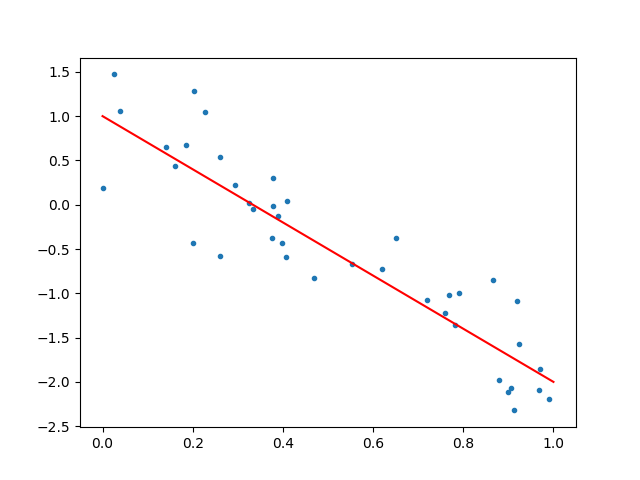

In [5]:
# Plot the data
plt.figure()
plt.plot(x_data[:,0], y_data, '.')
# Plot the regression line on top
x_loc = np.zeros([2, num_dim])
x_loc[1] = 1.0
y_loc = np.matmul(x_loc, true_weights) + true_intercept
plt.plot(x_loc, y_loc, color='red')

## Computational Graph

To create the computational graph, we need to know what the variables in the model are. In this session, we will declare as variables (`tf.Variable`) *only* those variables or parameters that need to be *trained*. In the regression case, we need to learn the weigth $w$ and the intercept $b$; the rest are constants (because the data is given).

**Declare the variables.** Each TensorFlow variable needs to be *initialized* at some value. We will initialize the weight variable randomly, and we will initialize the intercept to $0$.

In [6]:
weight = tf.Variable(tf.random_uniform([num_dim, 1], -1.0, 1.0))
intercept = tf.Variable(tf.constant(0.0, shape=[1, 1]))

**Compute the loss.** In linear regression, the loss is (average of the) squares of the difference between the predicted values $\hat{y}$ and the observed values $y$. Mathematically, it is
$$
\mathcal{L} = \frac{1}{N}\sum_{n=1}^{N} \left( \hat{y}_n - y_n \right)^2,\qquad
\textrm{with} \quad \hat{y}_n = b+w^\top x_n.
$$



In [7]:
y_predicted = intercept + tf.matmul(x_data, weight)
loss = tf.reduce_mean(tf.square(tf.squeeze(y_predicted) - y_data))

**Optimizer.** In linear regression, we minimize the loss $\mathcal{L}$ with respect to $w$ and $b$. That is, we need to find the values of these parameters that achieve the minimum possible value for $\mathcal{L}$. In the case of linear regression, we can analytically obtain this minimum. But we will pretend that we can't and we will ask the TensorFlow optimization engine to find it. (This will be helpful for other problems.)

In [8]:
# Define an optimizer. We will use a simple gradient descent optimizer
learning_rate = 0.2
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train = optimizer.minimize(loss) # We need to specify which variable we want to minimize

## Session

We can only evaluate variables and perform computations within a TensorFlow session. We create a session that:
1. Initializes the variables (weight and intercept).
2. Runs gradient descent to minimize the loss. We use a `for` loop for that.
3. Prints the progress.
4. Make a plot with the result.

**[Warning]** Depending on your TensorFlow version, you may get an error in the cell below. If you do, try replacing `tf.global_variables_initializer()` with `tf.initialize_all_variables()`.

Iteration=000, Loss=0.962845, Weight=-0.196569, Intercept=-0.216522
Iteration=050, Loss=0.209422, Weight=-2.402381, Intercept=0.694739
Iteration=100, Loss=0.175919, Weight=-2.871496, Intercept=0.957055
Iteration=150, Loss=0.174196, Weight=-2.977883, Intercept=1.016543
Iteration=200, Loss=0.174107, Weight=-3.002010, Intercept=1.030034
Iteration=250, Loss=0.174103, Weight=-3.007481, Intercept=1.033094
Iteration=300, Loss=0.174103, Weight=-3.008722, Intercept=1.033788
Iteration=350, Loss=0.174103, Weight=-3.009003, Intercept=1.033945
Iteration=400, Loss=0.174103, Weight=-3.009066, Intercept=1.033980
Iteration=450, Loss=0.174103, Weight=-3.009082, Intercept=1.033989
Iteration=500, Loss=0.174103, Weight=-3.009082, Intercept=1.033989
Iteration=550, Loss=0.174103, Weight=-3.009082, Intercept=1.033989
Iteration=600, Loss=0.174103, Weight=-3.009082, Intercept=1.033989
Iteration=650, Loss=0.174103, Weight=-3.009082, Intercept=1.033989
Iteration=700, Loss=0.174103, Weight=-3.009082, Intercept=1.0

<IPython.core.display.Javascript object>


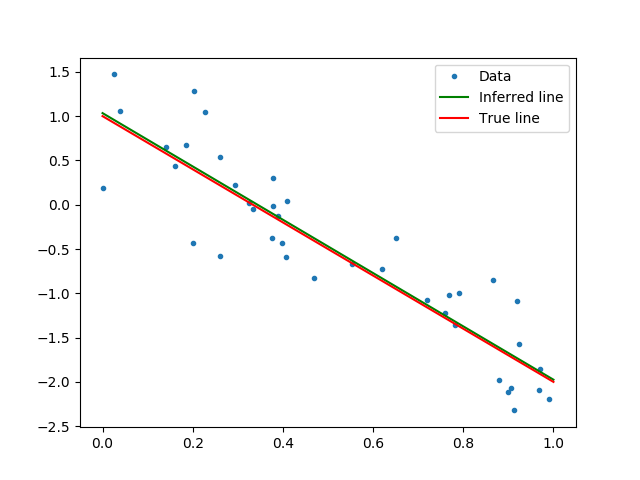

In [9]:
with tf.Session() as sess:
    # 1. Initialize all the variables
    tf.global_variables_initializer().run()
    # 2. Run (enough) steps of gradient descent
    for step in range(1001):
        sess.run(train)
        # 3. Print progress
        if step % 50 == 0:
            print('Iteration={:03d}, Loss={:f}, Weight={:f}, Intercept={:f}'.format(step, loss.eval(), tf.squeeze(weight).eval(), tf.squeeze(intercept).eval()))
    
    # 4. Plot the results
    plt.figure()
    plt.plot(x_data[:,0], y_data, '.')
    x_loc = np.zeros([2, num_dim]).astype(np.float32)
    x_loc[1] = 1.0
    y_loc = tf.matmul(x_loc, weight) + intercept
    plt.plot(x_loc, y_loc.eval(), color='green')
    plt.plot(x_loc, np.matmul(x_loc, true_weights) + true_intercept, color='red')
    plt.legend(['Data', 'Inferred line', 'True line'])

**[Question 1]** Why is there a small mismatch between the learned regression line and the true data-generating process?

**[Question 2]** Why do we make the final plot within a `session`? Can we do this after the session has ended?

**[Question 3]** Has the optimization converged? How can you tell? Do we need to increase or decrease the number of iterations?

**[Question 4]** Look at the value to which the loss converges. Should it correspond to any of the parameters in our code?

**[Task 1]** Set the value of the learning rate to $0.02$ and re-run the optimization. What happens? Why?

**[Task 2]** Set the value of the learning rate to $2.0$ and re-run the optimization. What happens? Why?

## Placeholders

In the code above, we feed the data directly, i.e., we use
```python
y_predicted = intercept + tf.matmul(x_data, weight)
loss = tf.reduce_mean(tf.square(tf.squeeze(y_predicted) - y_data))
```

Let's replace that with placeholders. That will we useful in future sessions for stochastic gradient descent. For now, we will not care about stochastic gradient descent, and we will just focus on feeding the data using placeholders.

We first need to declare the placeholders. This is similar to the declaration of a TensorFlow variable, except that we don't specify any value or initialization value for such variable; we only specify the type (integer, float, etc.) and the size of the tensor.

In [10]:
x_data_placeholder = tf.placeholder(tf.float32, (N, num_dim))
y_data_placeholder = tf.placeholder(tf.float32, (N))

**[Task]** Use the cell below to print `x_data_placeholder`. What information is displayed?

In [11]:
print(x_data_placeholder)

Tensor("Placeholder:0", shape=(40, 1), dtype=float32)


We now define a computational graph that uses the placeholders `x_data_placeholder` instead of the raw (numpy) data `x_data` (and similarly for `y`). Note that, once a placeholder has been declared, it can be used as a normal TensorFlow variable.

In [12]:
y_predicted = intercept + tf.matmul(x_data_placeholder, weight)
loss = tf.reduce_mean(tf.square(tf.squeeze(y_predicted) - y_data_placeholder))

The rest of the computational graph remains unchanged:

In [13]:
# Define an optimizer. We will use a simple gradient descent optimizer
learning_rate = 0.2
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train = optimizer.minimize(loss) # We need to specify which variable we want to minimize

The session also remains unchanged, except for one important detail. But first, let's copy and paste the code of the session above (we have removed the plotting for conciseness) and see what happens.

**Spoiler:** The code below gives an error!

In [14]:
with tf.Session() as sess:
    # 1. Initialize all the variables
    tf.global_variables_initializer().run()
    # 2. Run (enough) steps of gradient descent
    for step in range(1001):
        sess.run(train)
        # 3. Print progress
        if step % 50 == 0:
            print('Iteration={:03d}, Loss={:f}, Weight={:f}, Intercept={:f}'.format(step, loss.eval(), tf.squeeze(weight).eval(), tf.squeeze(intercept).eval()))

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [40,1]
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=[40,1], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Placeholder', defined at:
  File "C:\Users\Sheng\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Sheng\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Sheng\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Sheng\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Sheng\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\Sheng\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\Sheng\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\Sheng\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Sheng\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\Sheng\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Sheng\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Sheng\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Sheng\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Sheng\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Sheng\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Sheng\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Sheng\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Sheng\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Sheng\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Sheng\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-9216c54ea383>", line 1, in <module>
    x_data_placeholder = tf.placeholder(tf.float32, (N, num_dim))
  File "C:\Users\Sheng\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1507, in placeholder
    name=name)
  File "C:\Users\Sheng\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 1997, in _placeholder
    name=name)
  File "C:\Users\Sheng\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "C:\Users\Sheng\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\Sheng\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [40,1]
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=[40,1], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


**[Question]** Why did we get this error?

Let's now solve the error. The problem was that we made the promise to specify a value for the placeholder variables, but then we tried to run a session without having specified those values. To solve that, we need to create a "feeder dictionary" *within the session* using the following structure:
```python
feed_dict = {x_data_placeholder: ...,
             y_data_placeholder: ...}
```
In the snippet above, the ellipsis need to be replaced with the actual value that you want to feed. In our case, these are the corresponding numpy variables.

**[Task]** In the cell below, replace the ellipsis with the right variables so that the session can run with no errors.

In [15]:
with tf.Session() as sess:
    # 1. Initialize all the variables
    tf.global_variables_initializer().run()
    # Create the feeder dictionary
    feed_dict = {x_data_placeholder: ...,
                 y_data_placeholder: ...}
    
    # 2. Run (enough) steps of gradient descent
    for step in range(1001):
        # NOTE how we pass the feeder dictionary
        sess.run(train, feed_dict=feed_dict)
        # 3. Print progress
        if step % 50 == 0:
            # NOTE how we pass the feeder dictionary
            print('Iteration={:03d}, Loss={:f}, Weight={:f}, Intercept={:f}'.format(step, loss.eval(feed_dict=feed_dict), tf.squeeze(weight).eval(), tf.squeeze(intercept).eval()))

TypeError: float() argument must be a string or a number, not 'ellipsis'